In [129]:
block_size = 1024
vocabulary_size = 50257
embedding_dimensions = 1024
num_hidden_layers = 24

First, we'll estimate the total number of parameters in the network.

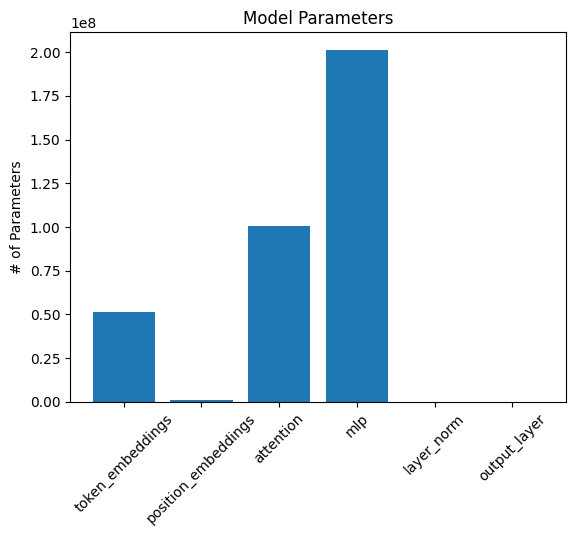

token_embeddings               51,463,168      14.51%
position_embeddings             1,048,576       0.30%
attention                     100,663,296      28.39%
mlp                           201,326,592      56.78%
layer_norm                         50,176       0.01%
output_layer                            0       0.00%


Total parameters: 354,551,808


In [130]:
import matplotlib.pyplot as plt

parameter_counts = {
    "token_embeddings": vocabulary_size * embedding_dimensions,
    "position_embeddings": block_size * embedding_dimensions,
    "attention": (embedding_dimensions ** 2 + embedding_dimensions * 3 * embedding_dimensions) * num_hidden_layers,
    "mlp": embedding_dimensions * 4 * embedding_dimensions * 2 * num_hidden_layers,
    "layer_norm": embedding_dimensions * num_hidden_layers * 2 + embedding_dimensions,
    "output_layer": 0, # Tied to token embeddings
}

plt.bar(parameter_counts.keys(), parameter_counts.values())

plt.title("Model Parameters")
plt.ylabel("# of Parameters")
plt.xticks(rotation=45)

plt.show()

total_parameter_count = sum(parameter_counts.values())

for name, count in parameter_counts.items():
    print(f"{name:20s} {count:20,d} {count / total_parameter_count * 100:10.2f}%")

print("\n")

print(f"Total parameters: {total_parameter_count:,}")

Next, we'll estimate the size of the model in memory and on disk. Note that this does not include any intermediate variables that get memorized during training such as activations and temporary buffers. Actual memory consumption will likely be much higher.

In [131]:
bytes_per_parameter = 32 // 8 # Assuming 32-bit floating point

buffers_per_parameter = 2 # Assuming Adam optimizer

total_values = total_parameter_count + buffers_per_parameter * total_parameter_count

total_bytes_per_parameter = total_values * bytes_per_parameter

total_gigabytes = total_bytes_per_parameter / 1e9

print(f"Total gigabytes: {total_gigabytes:,.2f}")

Total gigabytes: 4.25


Next, we'll estimate the maximum number of floating point operations (FLOPs) required to perform a full forward pass of the network on a single sample.

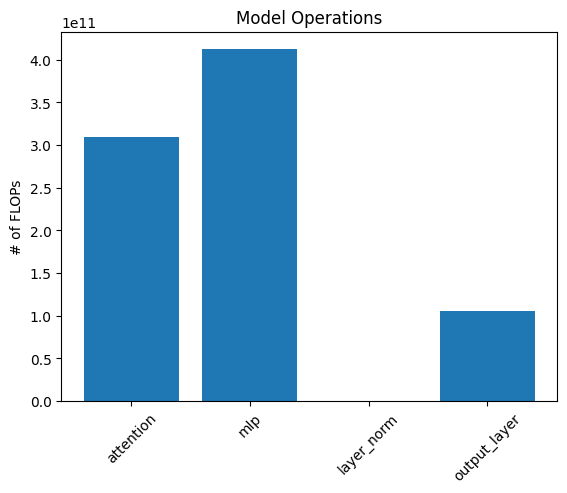

attention                 309,237,645,312      37.39%
mlp                       412,317,745,152      49.86%
layer_norm                        153,600       0.00%
output_layer              105,396,568,064      12.75%


Total forward FLOPs: 826,952,112,128


In [132]:
ops_per_matmul = 2 # Multiply + accumulate (MAC)
ops_per_activation = 9 # Assuming GELU
ops_per_layer_norm = 6 # Mean (1), variance (3), shift (1), scale (1)

# K, Q, V projections
attention = ops_per_matmul * block_size * embedding_dimensions * 3 * embedding_dimensions

# Attention logits
attention += 2 * ops_per_matmul * block_size ** 2 * embedding_dimensions

# Output projection
attention += ops_per_matmul * block_size * embedding_dimensions ** 2

attention *= num_hidden_layers

# Linear transformations
mlp = 2 * ops_per_matmul * block_size * embedding_dimensions * 4 * embedding_dimensions

# Non-linear activations
mlp += ops_per_activation * 4 * embedding_dimensions

mlp *= num_hidden_layers

layer_norm = ops_per_layer_norm * embedding_dimensions * (num_hidden_layers + 1)

output_layer = ops_per_matmul * block_size * embedding_dimensions * vocabulary_size

flops = {
    "attention": attention,
    "mlp": mlp,
    "layer_norm": layer_norm,
    "output_layer": output_layer,
}

plt.bar(flops.keys(), flops.values())

plt.title("Model Operations")
plt.ylabel("# of FLOPs")
plt.xticks(rotation=45)

plt.show()

total_forward_flops = sum(flops.values())

for name, count in flops.items():
    print(f"{name:20s} {count:20,d} {count / total_forward_flops * 100:10.2f}%")

print("\n")

print(f"Total forward FLOPs: {total_forward_flops:,}")

Next, we'll estimate the number of FLOPs for the backward pass. For this we use a simple heuristic of 2X the forward pass.

In [133]:
total_backward_flops = 2 * total_forward_flops

print(f"Total backward FLOPs: {total_backward_flops:,}")

Total backward FLOPs: 1,653,904,224,256


We'll do the same for the total FLOPs per roundtrip.

In [134]:
total_roundtrip_flops = total_forward_flops + total_backward_flops

print(f"Total roundtrip FLOPs: {total_roundtrip_flops:,}")

Total roundtrip FLOPs: 2,480,856,336,384


Now, let's estimate how long it would take to train over every sample in the Openwebtext training set at least once in expectation using a few well-known Nvidia GPUs as benchmarks. Note that these results shown here are a best-case scenario and neglect to factor in overhead such as moving data to and from VRAM.

In [135]:
RTX_A2000_BF16_FLOPS_PER_SECOND = 63.9e12
A100_SXM_BF16_FLOPS_PER_SECOND = 624.0e12
HGX_B100_BF16_FLOPS_PER_SECOND = 28000e12

ESTIMATED_FLOPS_UTILIZATION = 0.2

num_training_tokens = 8994885755
samples_per_epoch = 4096

num_epochs_required = round(num_training_tokens / (samples_per_epoch * block_size))

print(f"Total tokens: {num_training_tokens:,}")
print(f"Epochs required: {num_epochs_required:,}", end="\n\n")

gpus = {
    "RTX A2000": RTX_A2000_BF16_FLOPS_PER_SECOND,
    "A100 SXM": A100_SXM_BF16_FLOPS_PER_SECOND,
    "HGX B100": HGX_B100_BF16_FLOPS_PER_SECOND,
}

for name, flops_per_second in gpus.items():
    flops_per_second *= ESTIMATED_FLOPS_UTILIZATION

    seconds_per_epoch = samples_per_epoch * total_roundtrip_flops / flops_per_second

    days_required = num_epochs_required * seconds_per_epoch / 60 / 60 / 24

    print(f"{name}: {seconds_per_epoch:.2f} seconds/epoch, {days_required:,.2f} days required")

Total tokens: 8,994,885,755
Epochs required: 2,145

RTX A2000: 795.12 seconds/epoch, 19.74 days required
A100 SXM: 81.42 seconds/epoch, 2.02 days required
HGX B100: 1.81 seconds/epoch, 0.05 days required
